In [1]:
## Import Packages
from __future__ import print_function

import numpy as np

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cmplt
import matplotlib.pyplot as plt
from matplotlib import rcParams

#I/O
import glob
import copy
import time
import os
import scipy.io as sio
import imageio

from astropy.io import fits

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

In [9]:
## imports
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import filters
from skimage.transform import rescale

In [10]:
def read_fits(filename):
    with fits.open(filename) as hdul:
        data = hdul[0].data
        info = hdul[0].header
        data = data.astype(np.float64)
    return data[380:636,370:626]

def debayer(inpname):

    data = read_fits(inpname)

    # blue channel
    chan_blue = data[::2,::2]

    # red channel
    chan_red = data[1::2,1::2]

    # green channel
    chan_green_temp = np.zeros((int(data.shape[0]/2),data.shape[1]))
    for i in range(data.shape[1]):
        if ((i % 2) == 0):
            chan_green_temp[:,i] = data[1::2,i]
        else:
            chan_green_temp[:,i] = data[::2,i]
    chan_green = 0.5*(chan_green_temp[:,::2] + chan_green_temp[:,1::2])

    # construct image array
    im = np.zeros((chan_blue.shape[0],chan_blue.shape[1],3))
    im[:,:,0] = chan_red
    im[:,:,1] = chan_green
    im[:,:,2] = chan_blue

    return im

In [11]:
def obd(x,y,sf,maxiter,clipping=np.inf,srf=1):
    # x is estimate of deblurred image
    # y is observed image
    # sf size of psf
    # max iters for gradient descent
    # srf is super-resolution factor

    # make sure srf is >= 1
    if (srf < 1):
        raise Exception('Super-resolution factor must be >= 1.')

    # we will stay consistent with the notation to keep f as the psf
    sx = np.array(np.shape(x))
    sy = np.array(np.shape(y))

    # starting flux in y
    sumy = np.sum(y)

    ### Update/Guess the PSF

    #if there is already a guess for x, use it to guess f
    if sx[0] != 0:
        # starting flux in x
        sumx = np.sum(x)

        # mask out sat pixels in y
        mask = y>=clipping
        y[mask] = 0

        # initialize PSF as flat w/ correct intensity
        f = np.linalg.norm(np.ndarray.flatten(y)) / np.linalg.norm(np.ndarray.flatten(x))
        f = f * np.ones(sf) / np.sqrt(np.prod(sf, axis=0))

        #lets do GD on f given x and y
        #obd update(f,x,y)
        for i in range(0,maxiter[0]):
            #I am everywhere here making assumptions about sx,sf,and sy.
            #Just let me do that a minute please.
            ytmp = np.multiply(np.fft.fft2(x,s=sx), np.fft.fft2(f, s=sx))
            ytmp = setZero(np.real(np.fft.ifft2(ytmp)))[sf[0]-1:,sf[1]-1:]  #so they do not seem to do the np.real here... what does pos mean in that case?
            ytmp[mask] = 0

            Y = np.zeros(sx)
            Y[sf[0]-1:,sf[1]-1:] = rescale(y,srf,order=1)
            num = np.multiply(np.conj(np.fft.fft2(x,s=sx)),np.fft.fft2(Y,s=sx))
            num = setZero(np.real(np.fft.ifft2(num)))[:sf[0],:sf[0]]

            Y = np.zeros(sx)
            Y[sf[0]-1:,sf[1]-1:] = ytmp
            denom = np.multiply(np.conj(np.fft.fft2(x,s=sx)),np.fft.fft2(Y,s=sx))
            denom = setZero(np.real(np.fft.ifft2(denom)))[:sf[0],:sf[0]]

            tol = 1e-10
            factor = np.divide((num+tol),(denom+tol))
            factor = factor*filters.window(('tukey',0.3),(sf[0],sf[1]),warp_kwargs={'order':3}) #attempt to eliminate edge spikes
            f = np.multiply(f, factor)

        #this normalization seem suspect for making the light curve
        sumf = np.sum(f)
        f = f/sumf # normalize f
        x = sumf*x # adjust x as well
        #so this is shifting all the power from f to x
        #f is always unit normalized
        #now we guess the structure of x given y and that we have
        #renormalized x to have the same power as y

    #now that we have good guess for f, use it to guess x given y
        #lets do GD on x given f and y
        #obd update(x,f,y)
        for i in range(0,maxiter[1]):
            #I am everywhere here making assumptions about sx,sf,and sy.
            #Just let me do that a minute please.
            ytmp = np.multiply(np.fft.fft2(x,s=sx), np.fft.fft2(f, s=sx))
            ytmp = setZero(np.real(np.fft.ifft2(ytmp)))[sf[0]-1:,sf[1]-1:]  #so they do not seem to do the np.real here... what does pos mean in that case?
            ytmp[mask] = 0

            Y = np.zeros(sx)
            Y[sf[0]-1:,sf[1]-1:] = rescale(y,srf,order=1)
            num = np.multiply(np.conj(np.fft.fft2(f,s=sx)),np.fft.fft2(Y,s=sx))
            num = setZero(np.real(np.fft.ifft2(num)))

            Y = np.zeros(sx)
            Y[sf[0]-1:,sf[1]-1:] = ytmp
            denom = np.multiply(np.conj(np.fft.fft2(f,s=sx)),np.fft.fft2(Y,s=sx))
            denom = setZero(np.real(np.fft.ifft2(denom)))

            tol = 1e-10
            factor = np.divide((num+tol),(denom+tol))
            factor = factor*filters.window(('tukey',0.3),(sx[0],sx[1]),warp_kwargs={'order':3}) #attempt to eliminate edge spikes
            x = np.multiply(x, factor)

        sumx = np.sum(x)
#         avg = np.mean((sumx,sumy))
#         x = avg/sumx*x
        x = sumy/sumx*x

        return x, f

    #intialization of f from scratch
    else:
        f = np.zeros(sf)
        mid = int(f.shape[0]/2)
        f[mid,mid] = 1 #delta function intialization
        # make the guess for x to be size of sy padded by sf

    #using our intialization of f, use it to guess x given y
        ## here I am assuming sf<sy
        sx = sf + sy - 1
        if (srf > 1):
            sx = sf + (srf*sy) - 1

        Y = np.zeros(sx)
        Y[sf[0]-1:,sf[1]-1:] = rescale(y,srf,order=1) #should we do something better than bilinear?
        x = np.multiply(np.conj(np.fft.fft2(f,s=sx)),np.fft.fft2(Y,s=sx))
        x = setZero(np.real(np.fft.ifft2(x)))
        ## to be clear, this is a waste of time, beacuse we know we are choosing x=y1
        ## that is what the delta function means.
        ## This was useful coding practice because it means the image is centered using my conventions
        ## need to understand why this padding is really necessary
        ## these lines may be useful for srf cases which we are ignoring rn
        sumx = np.sum(x)
        x = sumy/sumx*x
        return x, f

# function that converts all negative elements to zero
def setZero(x):
    x[x<0] = 0
    return x

100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


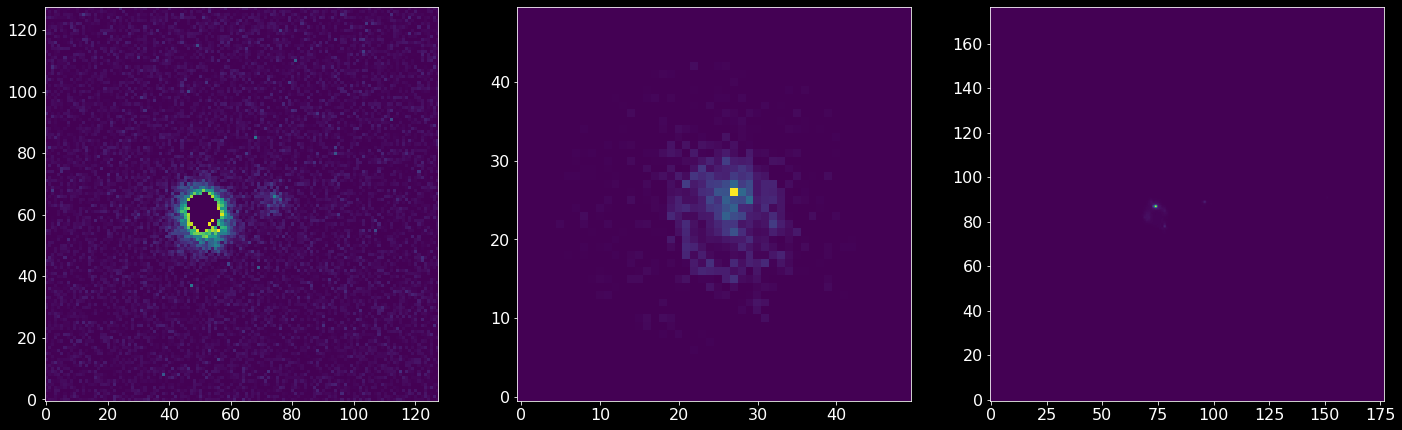

In [12]:
## parameters
sf = np.array([50, 50])       # size of the PSF
maxiter = [40, 1]    # number of iterations for f and x
n = 100              # number of images
clipping = np.inf      # maximally acceptable pixel (for saturation correction)
srf = 1.0           # superresolution factor

base = '/Users/saydjari/Dropbox/GradSchool_AKS/Doug/ExtData/HOP/2021_02_25/'
directory = 'TIC_72090501.01/2021-02-26_00_56_38Z/'

# intially there is no x
flux_x = []
flux_y = []
flux_f = []
x = np.array([])
for j in tqdm(range(0,n)):
    y = debayer(base+directory+'2021-02-26-0056_6-CapObj_{:0>4d}.FIT'.format(j))[:,:,1]
    flux_y.append(np.sum(y))
    x, f = obd(x, y, sf, maxiter,clipping=65500)
#     fig, ax = plt.subplots(1,3, figsize=(24., 8.))
#     ax[0].imshow(y, origin='lower')
#     ax[1].imshow(f, origin='lower')
#     ax[2].imshow(x, origin='lower')
#     plt.show()
    flux_x.append(np.sum(x))
    flux_f.append(np.sum(f))
    
# sumy = np.mean(flux_y)
# sumx = np.mean(x)
# x = sumy/sumx*x

fig, ax = plt.subplots(1,3, figsize=(24., 8.))
ax[0].imshow(y, origin='lower')
ax[1].imshow(f, origin='lower')
ax[2].imshow(x, origin='lower')
plt.show()

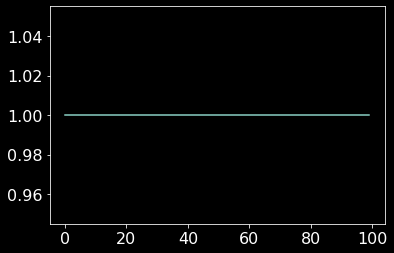

In [13]:
plt.plot(np.array(flux_x)/np.array(flux_y))

<ipython-input-14-50c2c735d5bf>:4: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(x),


[]

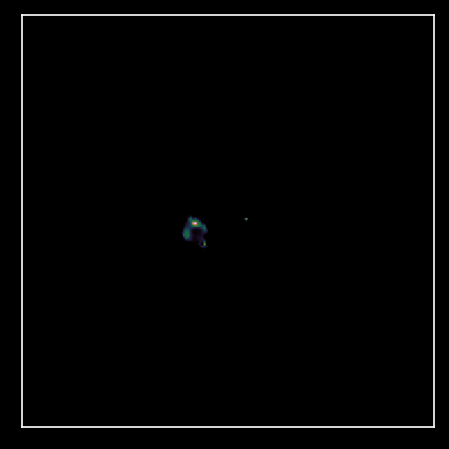

In [14]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(2,2,1)
im = plt.imshow(np.log10(x),
                cmap='cubehelix',
                vmin=4.5,
                vmax=7,
                origin='lower'
               )
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

In [40]:
def obd(x,y,sf,maxiter,clipping=np.inf,srf=1):
    # x is estimate of deblurred image
    # y is observed image
    # sf size of psf
    # max iters for gradient descent
    # srf is super-resolution factor

    # make sure srf is >= 1
    if (srf < 1):
        raise Exception('Super-resolution factor must be >= 1.')

    # we will stay consistent with the notation to keep f as the psf
    sx = np.array(np.shape(x))
    sy = np.array(np.shape(y))

    # starting flux in y
    sumy = np.sum(y)

    ### Update/Guess the PSF

    #if there is already a guess for x, use it to guess f
    if sx[0] != 0:
        # starting flux in x
        sumx = np.sum(x)

        # initialize PSF as flat w/ correct intensity
        f = np.linalg.norm(np.ndarray.flatten(y)) / np.linalg.norm(np.ndarray.flatten(x))
        f = f * np.ones(sf) / np.sqrt(np.prod(sf, axis=0))

        # srf by rescaling (done once at the front)
        y = rescale(y,srf,order=1)

        # mask out sat pixels in y
        mask = y>=clipping
        y[mask] = 0

        #lets do GD on f given x and y
        #obd update(f,x,y)
        for i in range(0,maxiter[0]):
            #I am everywhere here making assumptions about sx,sf,and sy.
            #Just let me do that a minute please.
            ytmp = np.multiply(np.fft.fft2(x,s=sx), np.fft.fft2(f, s=sx))
            ytmp = setZero(np.real(np.fft.ifft2(ytmp)))[sf[0]-1:,sf[1]-1:]  #so they do not seem to do the np.real here... what does pos mean in that case?
            ytmp[mask] = 0

            Y = np.zeros(sx)
            Y[sf[0]-1:,sf[1]-1:] = y
            num = np.multiply(np.conj(np.fft.fft2(x,s=sx)),np.fft.fft2(Y,s=sx))
            num = setZero(np.real(np.fft.ifft2(num)))[:sf[0],:sf[0]]

            Y = np.zeros(sx)
            Y[sf[0]-1:,sf[1]-1:] = ytmp
            denom = np.multiply(np.conj(np.fft.fft2(x,s=sx)),np.fft.fft2(Y,s=sx))
            denom = setZero(np.real(np.fft.ifft2(denom)))[:sf[0],:sf[0]]

            tol = 1e-10
            factor = np.divide((num+tol),(denom+tol))
            factor = factor*filters.window(('tukey',0.1),(sf[0],sf[1]),warp_kwargs={'order':3}) #attempt to eliminate edge spikes
            f = np.multiply(f, factor)

        #this normalization seem suspect for making the light curve
        sumf = np.sum(f)
        f = f/sumf # normalize f
        x = sumf*x # adjust x as well
        #so this is shifting all the power from f to x
        #f is always unit normalized
        #now we guess the structure of x given y and that we have
        #renormalized x to have the same power as y

    #now that we have good guess for f, use it to guess x given y
        #lets do GD on x given f and y
        #obd update(x,f,y)
        for i in range(0,maxiter[1]):
            #I am everywhere here making assumptions about sx,sf,and sy.
            #Just let me do that a minute please.
            ytmp = np.multiply(np.fft.fft2(x,s=sx), np.fft.fft2(f, s=sx))
            ytmp = setZero(np.real(np.fft.ifft2(ytmp)))[sf[0]-1:,sf[1]-1:]  #so they do not seem to do the np.real here... what does pos mean in that case?
            ytmp[mask] = 0

            Y = np.zeros(sx)
            Y[sf[0]-1:,sf[1]-1:] = y
            num = np.multiply(np.conj(np.fft.fft2(f,s=sx)),np.fft.fft2(Y,s=sx))
            num = setZero(np.real(np.fft.ifft2(num)))

            Y = np.zeros(sx)
            Y[sf[0]-1:,sf[1]-1:] = ytmp
            denom = np.multiply(np.conj(np.fft.fft2(f,s=sx)),np.fft.fft2(Y,s=sx))
            denom = setZero(np.real(np.fft.ifft2(denom)))

            tol = 1e-10
            factor = np.divide((num+tol),(denom+tol))
            factor = factor*filters.window(('tukey',2*sf[0]/sx[0]),(sx[0],sx[1]),warp_kwargs={'order':3}) #attempt to eliminate edge spikes
            x = np.multiply(x, factor)

        sumx = np.sum(x)
#         avg = np.mean((sumx,sumy))
#         x = avg/sumx*x
        x = sumy/sumx*x

        return x, f, y

    #intialization of f from scratch
    else:
        f = np.zeros(sf)
        mid = int(f.shape[0]/2)
        f[mid,mid] = 1 #delta function intialization
        # make the guess for x to be size of sy padded by sf

    #using our intialization of f, use it to guess x given y
        ## here I am assuming sf<sy
        sx = sf + sy - 1
        if (srf > 1):
            sx = sf + (srf*sy) - 1

        Y = np.zeros(sx)
        Y[sf[0]-1:,sf[1]-1:] = rescale(y,srf,order=1) #should we do something better than bilinear?
        x = np.multiply(np.conj(np.fft.fft2(f,s=sx)),np.fft.fft2(Y,s=sx))
        x = setZero(np.real(np.fft.ifft2(x)))
        ## to be clear, this is a waste of time, beacuse we know we are choosing x=y1
        ## that is what the delta function means.
        ## This was useful coding practice because it means the image is centered using my conventions
        ## need to understand why this padding is really necessary
        ## these lines may be useful for srf cases which we are ignoring rn
        sumx = np.sum(x)
        x = sumy/sumx*x
        return x, f, y

# function that converts all negative elements to zero
def setZero(x):
    x[x<0] = 0
    return x

100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


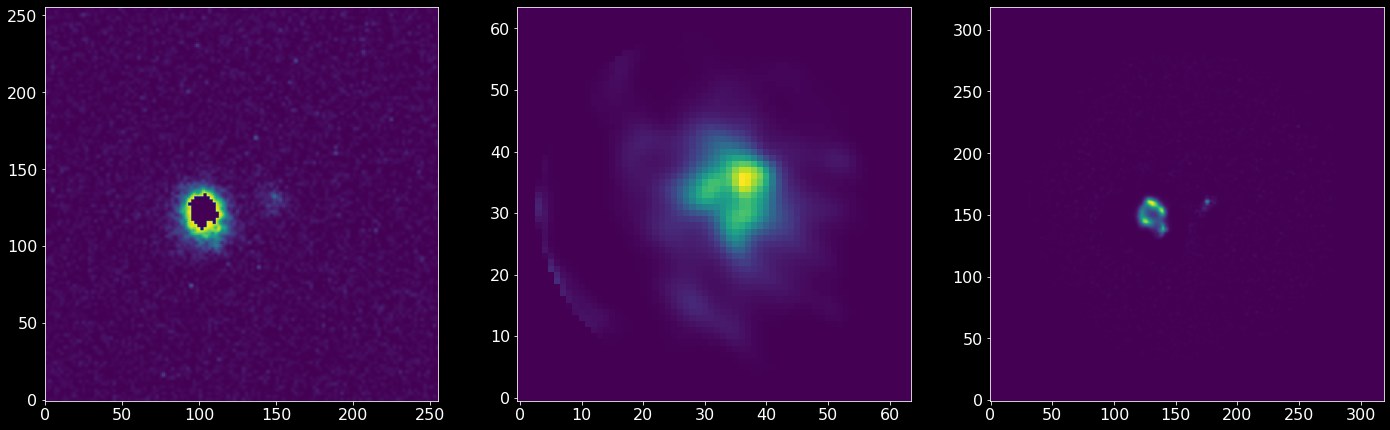

In [34]:
## parameters
sf = np.array([64, 64])       # size of the PSF
maxiter = [40, 1]    # number of iterations for f and x
n = 100              # number of images
clipping = 65400      # maximally acceptable pixel (for saturation correction)
srf = 2            # superresolution factor

base = '/Users/saydjari/Dropbox/GradSchool_AKS/Doug/ExtData/HOP/2021_02_25/'
directory = 'TIC_72090501.01/2021-02-26_00_56_38Z/'

# intially there is no x
flux_x = []
flux_y = []
flux_f = []
x = np.array([])
for j in tqdm(range(0,n)):
    y = debayer(base+directory+'2021-02-26-0056_6-CapObj_{:0>4d}.FIT'.format(j))[:,:,1]
    flux_y.append(np.sum(y))
    x, f, y= obd(x, y, sf, maxiter,clipping=clipping,srf=srf)
#     fig, ax = plt.subplots(1,3, figsize=(24., 8.))
#     ax[0].imshow(y, origin='lower')
#     ax[1].imshow(f, origin='lower')
#     ax[2].imshow(x, origin='lower')
#     plt.show()
    flux_x.append(np.sum(x))
    flux_f.append(np.sum(f))
    
# sumy = np.mean(flux_y)
# sumx = np.mean(x)
# x = sumy/sumx*x

fig, ax = plt.subplots(1,3, figsize=(24., 8.))
ax[0].imshow(y, origin='lower')
ax[1].imshow(f, origin='lower')
ax[2].imshow(x, origin='lower')
plt.show()

100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


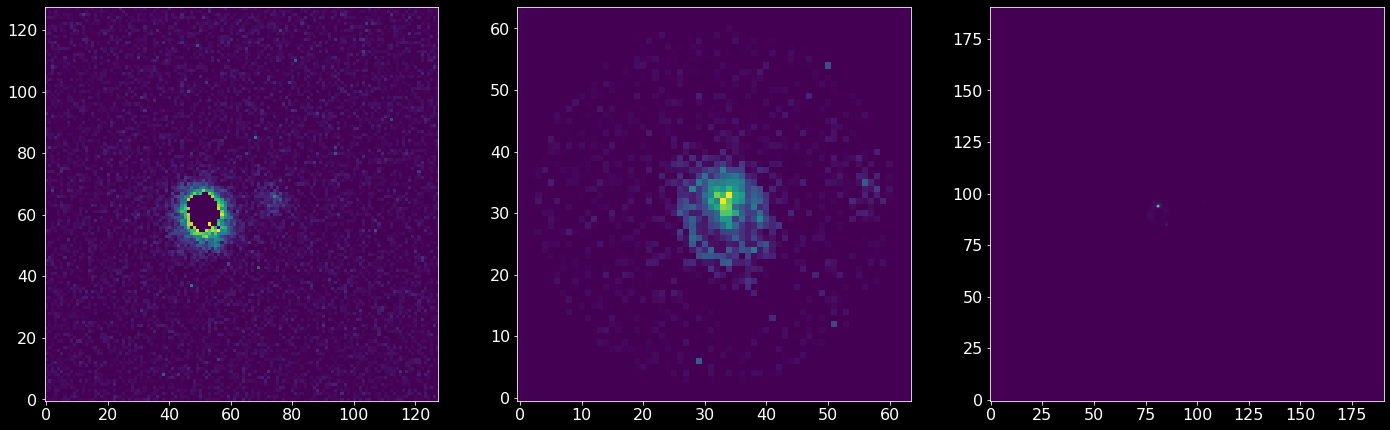

In [35]:
## parameters
sf = np.array([64, 64])       # size of the PSF
maxiter = [40, 1]    # number of iterations for f and x
n = 100              # number of images
clipping = 65400      # maximally acceptable pixel (for saturation correction)
srf = 1            # superresolution factor

base = '/Users/saydjari/Dropbox/GradSchool_AKS/Doug/ExtData/HOP/2021_02_25/'
directory = 'TIC_72090501.01/2021-02-26_00_56_38Z/'

# intially there is no x
flux_x = []
flux_y = []
flux_f = []
x = np.array([])
for j in tqdm(range(0,n)):
    y = debayer(base+directory+'2021-02-26-0056_6-CapObj_{:0>4d}.FIT'.format(j))[:,:,1]
    flux_y.append(np.sum(y))
    x, f, y= obd(x, y, sf, maxiter,clipping=clipping,srf=srf)
#     fig, ax = plt.subplots(1,3, figsize=(24., 8.))
#     ax[0].imshow(y, origin='lower')
#     ax[1].imshow(f, origin='lower')
#     ax[2].imshow(x, origin='lower')
#     plt.show()
    flux_x.append(np.sum(x))
    flux_f.append(np.sum(f))
    
# sumy = np.mean(flux_y)
# sumx = np.mean(x)
# x = sumy/sumx*x

fig, ax = plt.subplots(1,3, figsize=(24., 8.))
ax[0].imshow(y, origin='lower')
ax[1].imshow(f, origin='lower')
ax[2].imshow(x, origin='lower')
plt.show()

<ipython-input-36-50c2c735d5bf>:4: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(x),


[]

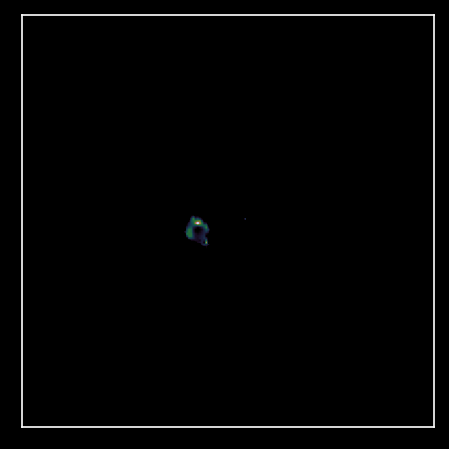

In [36]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(2,2,1)
im = plt.imshow(np.log10(x),
                cmap='cubehelix',
                vmin=4.5,
                vmax=7,
                origin='lower'
               )
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


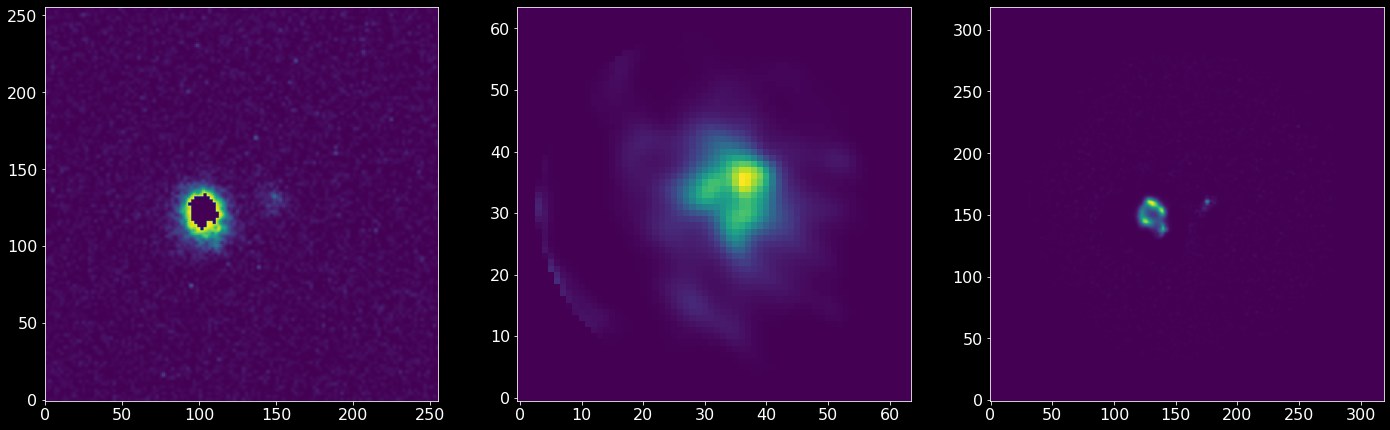

In [42]:
## parameters
sf = np.array([64, 64])       # size of the PSF
maxiter = [40, 1]    # number of iterations for f and x
n = 100              # number of images
clipping = 65400      # maximally acceptable pixel (for saturation correction)
srf = 2            # superresolution factor

base = '/Users/saydjari/Dropbox/GradSchool_AKS/Doug/ExtData/HOP/2021_02_25/'
directory = 'TIC_72090501.01/2021-02-26_00_56_38Z/'

# intially there is no x
flux_x = []
flux_y = []
flux_f = []
x = np.array([])
for j in tqdm(range(0,n)):
    y = debayer(base+directory+'2021-02-26-0056_6-CapObj_{:0>4d}.FIT'.format(j))[:,:,1]
    flux_y.append(np.sum(y))
    x, f, y= obd(x, y, sf, maxiter,clipping=clipping,srf=srf)
#     fig, ax = plt.subplots(1,3, figsize=(24., 8.))
#     ax[0].imshow(y, origin='lower')
#     ax[1].imshow(f, origin='lower')
#     ax[2].imshow(x, origin='lower')
#     plt.show()
    flux_x.append(np.sum(x))
    flux_f.append(np.sum(f))
    
# sumy = np.mean(flux_y)
# sumx = np.mean(x)
# x = sumy/sumx*x

fig, ax = plt.subplots(1,3, figsize=(24., 8.))
ax[0].imshow(y, origin='lower')
ax[1].imshow(f, origin='lower')
ax[2].imshow(x, origin='lower')
plt.show()

In [44]:
from skimage.feature import peak_local_max

In [90]:
coordinates = peak_local_max(np.log10(x), min_distance=10,threshold_abs=4)

<ipython-input-90-5325888bdd5d>:1: RuntimeWarning: divide by zero encountered in log10
  coordinates = peak_local_max(np.log10(x), min_distance=10,threshold_abs=4)


In [91]:
coordinates

array([[160, 130],
       [145, 125],
       [139, 140],
       [161, 175]])

<ipython-input-92-3d0a32adc0a4>:4: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(x),


[]

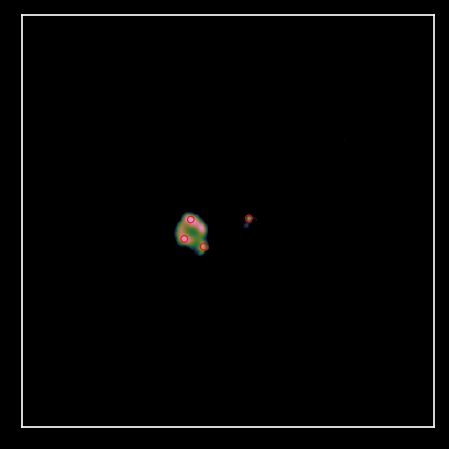

In [92]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(2,2,1)
im = plt.imshow(np.log10(x),
                cmap='cubehelix',
                vmin=3.5,
                vmax=5.5,
                origin='lower'
               )
ax.scatter(coordinates[:, 1], coordinates[:, 0],alpha=0.9,facecolor="none",edgecolor='r', lw=0.5,s=10)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

In [61]:
np.max(np.log10(x))

<ipython-input-61-3c4e40f518a6>:1: RuntimeWarning: divide by zero encountered in log10
  np.max(np.log10(x))


4.902036224858175

In [93]:
coordinates = peak_local_max(np.log10(x), min_distance=25,threshold_abs=4)

<ipython-input-93-d348301b1644>:1: RuntimeWarning: divide by zero encountered in log10
  coordinates = peak_local_max(np.log10(x), min_distance=25,threshold_abs=4)


<ipython-input-94-3d0a32adc0a4>:4: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(x),


[]

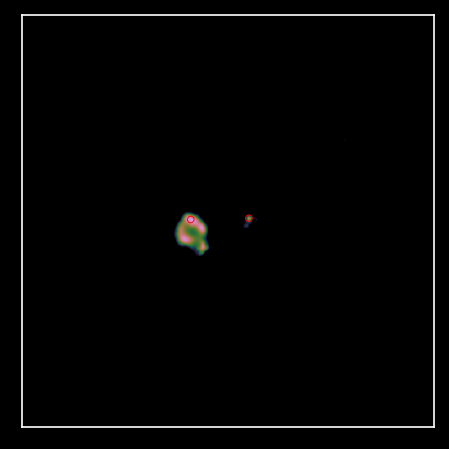

In [94]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(2,2,1)
im = plt.imshow(np.log10(x),
                cmap='cubehelix',
                vmin=3.5,
                vmax=5.5,
                origin='lower'
               )
ax.scatter(coordinates[:, 1], coordinates[:, 0],alpha=0.9,facecolor="none",edgecolor='r', lw=0.5,s=10)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

In [98]:
test_center = coordinates[0]

In [104]:
temp = x[test_center[0]-4:test_center[0]+5,test_center[1]-4:test_center[1]+5]

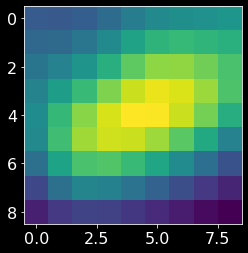

In [105]:
plt.imshow(temp)

In [106]:
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

In [107]:
temp.shape

(9, 9)

In [109]:
radial_profile(temp,(4,4))

array([79806.1251434 , 73725.62196858, 60334.17933572, 46720.47982661,
       35016.77576755, 26152.59866955])